In [1]:
# Tutorial of  Label Free Physics-Constrained machine learning:
# 2D pipe flow cases
# More examples can be cound in paper: 
#"Surrogate modeling for fluid flows based on physics-constrained deep learning without simulation data"
# https://www.sciencedirect.com/science/article/pii/S004578251930622X

In [ ]:
# This code works at tensorflow 1.15

In [5]:
import numpy as np
import tensorflow as tf
import pdb
from matplotlib import pyplot as plt


re = 200.0    # Reynolds number re = U(2R)/nu
nuMean = 0.001
nuStd = 0.9
L = 1.0      # length of pipe
R = 0.05       #
rho = 1       # density
periodicBC = True # or false
dP = 0.1

eps = 1e-4
coef_reg = 1e-5

learning_rate = 5e-3
npoch = 1000# 5000
batch_size = 128

N_x = 10
N_y = 50
N_p = 50

n_h = 50
display_step = 100

xStart = 0
xEnd = xStart + L
yStart = -R
yEnd = yStart + 2*R

## prepare data with (?, 2)
data_1d_x = np.linspace(xStart, xEnd, N_x, endpoint=True)
data_1d_y = np.linspace(yStart, yEnd, N_y, endpoint=True)
nuStart = nuMean-nuMean*nuStd
nuEnd = nuMean+nuMean*nuStd
# nuStart = 0.0001
# nuEnd = 0.1
data_1d_nu = np.linspace(nuStart, nuEnd, N_p, endpoint=True)
print('train_nu is',data_1d_nu)
np.savez('train_nu',nu_1d = data_1d_nu)


data_2d_xy_before = np.array(np.meshgrid(data_1d_x, data_1d_y, data_1d_nu))
data_2d_xy_before_reshape = data_2d_xy_before.reshape(3, -1)
data_2d_xy = data_2d_xy_before_reshape.T



num_steps = npoch*(N_x*N_y*N_p)/batch_size


def myswish_beta(x):
    """
    Swish activation - with beta not-traininable!

    """
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish_beta')
    return x * tf.nn.sigmoid(x*beta)

class classDataGenerator(object):

    def __init__(self, data_2d_xy):

        self.data = np.copy(data_2d_xy)
        np.random.shuffle(self.data)

        self.batch_index = 0
        self.total_data_num = self.data.shape[0]

    def next_batch(self, batch_size):

        if self.batch_index + batch_size < self.total_data_num:

            batch_x = self.data[self.batch_index: self.batch_index + batch_size, 0]
            batch_y = self.data[self.batch_index: self.batch_index + batch_size, 1]
            batch_nu = self.data[self.batch_index: self.batch_index + batch_size, 2]
            self.batch_index = self.batch_index + batch_size

        else:

            batch_x = self.data[self.batch_index: self.total_data_num, 0]
            batch_y = self.data[self.batch_index: self.total_data_num, 1]
            batch_nu = self.data[self.batch_index: self.batch_index + batch_size, 2]
            self.batch_index = 0

        batch_x = batch_x.reshape(-1,1)
        batch_y = batch_y.reshape(-1,1)
        batch_nu = batch_nu.reshape(-1,1)

        return batch_x, batch_y, batch_nu


act = myswish_beta


x = tf.placeholder('float',[None, 1])
y = tf.placeholder('float',[None, 1])
nu = tf.placeholder('float', [None, 1])
res_true = tf.placeholder('float', [None, 1])

if periodicBC:
    b = 2*np.pi/(xEnd-xStart)
    c = np.pi*(xStart+xEnd)/(xStart-xEnd)
    sin_x = xStart*tf.sin(b*x+c)
    cos_x = xStart*tf.cos(b*x+c)
    n1Layer = 4
    input = tf.concat([sin_x, cos_x, y, nu], axis=1)
else:
    n1Layer = 3
    input = tf.concat([x, y, nu], axis=1)

init = tf.contrib.layers.xavier_initializer()
# U
W_1_u = tf.Variable(init([n1Layer, n_h]))
W_2_u = tf.Variable(init([n_h, n_h]))
W_3_u = tf.Variable(init([n_h, n_h]))
W_4_u = tf.Variable(init([n_h, 1]))

b_1_u = tf.Variable(init([1, n_h]))
b_2_u = tf.Variable(init([1, n_h]))
b_3_u = tf.Variable(init([1, n_h]))
b_4_u = tf.Variable(init([1, 1]))

# v
W_1_v = tf.Variable(init([n1Layer, n_h]))
W_2_v = tf.Variable(init([n_h, n_h]))
W_3_v = tf.Variable(init([n_h, n_h]))
W_4_v = tf.Variable(init([n_h, 1]))

b_1_v = tf.Variable(init([1, n_h]))
b_2_v = tf.Variable(init([1, n_h]))
b_3_v = tf.Variable(init([1, n_h]))
b_4_v = tf.Variable(init([1, 1]))


# p
W_1_p = tf.Variable(init([n1Layer, n_h]))
W_2_p = tf.Variable(init([n_h, n_h]))
W_3_p = tf.Variable(init([n_h, n_h]))
W_4_p = tf.Variable(init([n_h, 1]))

b_1_p = tf.Variable(init([1, n_h]))
b_2_p = tf.Variable(init([1, n_h]))
b_3_p = tf.Variable(init([1, n_h]))
b_4_p = tf.Variable(init([1, 1]))


# u_nn(x,y)
u_nn = tf.matmul(act(tf.matmul(act(tf.matmul(act(tf.matmul(input, W_1_u) + b_1_u), W_2_u) + b_2_u), W_3_u) + b_3_u), W_4_u) + b_4_u

# v_nn(x,y)
v_nn = tf.matmul(act(tf.matmul(act(tf.matmul(act(tf.matmul(input, W_1_v) + b_1_v), W_2_v) + b_2_v), W_3_v) + b_3_v), W_4_v) + b_4_v

# p_nn(x,y)
p_nn = tf.matmul(act(tf.matmul(act(tf.matmul(act(tf.matmul(input, W_1_p) + b_1_p), W_2_p) + b_2_p), W_3_p) + b_3_p), W_4_p) + b_4_p


# data generator
dataGenerator = classDataGenerator(data_2d_xy=data_2d_xy)


#################################
# enforcing boudnary condition 
#################################

# u = tf.nn.tanh(eps/(1.0 + 0.2*eps - y)) + (1.0 - x**2)*(1.0 - y**2)*u_nn

# u = tf.nn.tanh(eps/(1.0 + 0.2*eps - y)) + (1.0 - x**2)*(1.0 - y**2)*u_nn


# Impose pressure gradient as a constant
# u = u_nn*(R**2 - y**2)
# v = (R - y**2)*v_nn
# p = dP - dP*(x-xStart)/L + 0*y

# Impose pressure drop
u = u_nn*(R**2 - y**2)
v = (R**2 - y**2)*v_nn
p = (xStart-x)*0 + dP*(xEnd-x)/L + 0*y + (xStart - x)*(xEnd - x)*p_nn
#p = (1-x)*200 + (1+x)*0 + (1 - x**2)*p_nn # iniitial loss is super large

# Impose velocity
#u = tf.nn.tanh(eps/(1.0 + 0.2*eps + x)) + u_nn*(1.0 - y**2)*(1.0 + x)
#v = (1.0 - x**2)*(1.0 - y**2)*v_nn
#p = p_nn


#################################
# enforcing PDE loss 
#################################

dudx = tf.gradients(u,x)[0]

dudy = tf.gradients(u,y)[0]

du2dx2 = tf.gradients(dudx,x)[0]

du2dy2 = tf.gradients(dudy,y)[0]

dvdx = tf.gradients(v,x)[0]

dvdy = tf.gradients(v,y)[0]

dv2dx2 = tf.gradients(dvdx,x)[0]

dv2dy2 = tf.gradients(dvdy,y)[0]


dpdx = tf.gradients(p,x)[0]

dpdy = tf.gradients(p,y)[0]




# Res for N-S equation
res_mom_u = u*dudx + v*dudy + 1/rho*dpdx - (du2dx2 + du2dy2)*nu
res_mom_v = u*dvdx + v*dvdy + 1/rho*dpdy - (dv2dx2 + dv2dy2)*nu
res_cont  = dudx + dvdy



loss = tf.reduce_mean(tf.pow(res_true - res_mom_u, 2)) + \
       tf.reduce_mean(tf.pow(res_true - res_mom_v, 2)) + \
       tf.reduce_mean(tf.pow(res_true - res_cont, 2)) 


optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)



init = tf.global_variables_initializer()

with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, int(num_steps+1)):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, batch_y, batch_nu = dataGenerator.next_batch(batch_size)

        res_batch = np.zeros(batch_x.shape)


        # Run optimization op (backprop) and cost op (to get loss value)
        # train_step.minimize(sess, feed_dict={x: batch_x, y: batch_y, res_true: res_batch})

        # compute loss
        # l = sess.run(loss, feed_dict={x: batch_x, y: batch_y, res_true: res_batch})
        
        _, l = sess.run([optimizer, loss], feed_dict={x: batch_x, y: batch_y, nu: batch_nu, res_true: res_batch})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

    u_pred_2d_xy_list = sess.run([u,v,p], feed_dict={x: data_2d_xy[:,0:1], y: data_2d_xy[:,1:2], 
                                             nu: data_2d_xy[:,2:3], res_true: np.zeros(data_2d_xy[:,0:1].shape)})


    # test normal distribution of maxvelocity
    #N_pTest = 200
    N_pTest = 500
    data_1d_nuDist = np.random.normal(nuMean, 0.2*nuMean, N_pTest)
    data_2d_xy_before_test = np.array(np.meshgrid((xStart-xEnd)/2., 0, data_1d_nuDist))
    data_2d_xy_before_test_reshape = data_2d_xy_before_test.reshape(3, -1)
    data_2d_xy_test = data_2d_xy_before_test_reshape.T
    data_2d_xy_test = data_2d_xy_before_test_reshape.T
    uMax_pred_list = sess.run([u,v,p], feed_dict={x: data_2d_xy_test[:,0:1], y: data_2d_xy_test[:,1:2], 
                                         nu: data_2d_xy_test[:,2:3], res_true: np.zeros(data_2d_xy_test[:,0:1].shape)})

#print('shape of uMax_pred',uMax_pred.shape)

uMax_pred = uMax_pred_list[0].T
print('uMax_pred is',uMax_pred)
print('shape of uMax_pred is',uMax_pred.shape)


u_pred_2d_xy = u_pred_2d_xy_list[0].T
v_pred_2d_xy = u_pred_2d_xy_list[1].T
p_pred_2d_xy = u_pred_2d_xy_list[2].T

u_pred_2d_xy_mesh = u_pred_2d_xy.reshape(N_y, N_x, N_p)
v_pred_2d_xy_mesh = v_pred_2d_xy.reshape(N_y, N_x, N_p)
p_pred_2d_xy_mesh = p_pred_2d_xy.reshape(N_y, N_x, N_p)

# analytical solution
uSolaM = np.zeros([N_y, N_x, N_p])
for i in range(N_p):
    uy = (R**2 - data_1d_y**2)*dP/(2*L*data_1d_nu[i]*rho)
    uSolaM[:, :, i] = np.tile(uy.reshape([N_y, 1]), N_x)

uMax_a = np.zeros([1, N_pTest])
for i in range(N_pTest):
    uMax_a[0, i] = (R**2)*dP/(2*L*data_1d_nuDist[i]*rho)

print (data_2d_xy_before.shape)

print (u_pred_2d_xy_mesh.shape)


np.savez('pred_poiseuille_para', mesh=data_2d_xy_before, u=u_pred_2d_xy_mesh, 
                            v=v_pred_2d_xy_mesh, p=p_pred_2d_xy_mesh, ut=uSolaM,
                            uMaxP=uMax_pred, uMaxA=uMax_a)

train_nu is [1.00000000e-04 1.36734694e-04 1.73469388e-04 2.10204082e-04
 2.46938776e-04 2.83673469e-04 3.20408163e-04 3.57142857e-04
 3.93877551e-04 4.30612245e-04 4.67346939e-04 5.04081633e-04
 5.40816327e-04 5.77551020e-04 6.14285714e-04 6.51020408e-04
 6.87755102e-04 7.24489796e-04 7.61224490e-04 7.97959184e-04
 8.34693878e-04 8.71428571e-04 9.08163265e-04 9.44897959e-04
 9.81632653e-04 1.01836735e-03 1.05510204e-03 1.09183673e-03
 1.12857143e-03 1.16530612e-03 1.20204082e-03 1.23877551e-03
 1.27551020e-03 1.31224490e-03 1.34897959e-03 1.38571429e-03
 1.42244898e-03 1.45918367e-03 1.49591837e-03 1.53265306e-03
 1.56938776e-03 1.60612245e-03 1.64285714e-03 1.67959184e-03
 1.71632653e-03 1.75306122e-03 1.78979592e-03 1.82653061e-03
 1.86326531e-03 1.90000000e-03]
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflo

Step 18500: Minibatch Loss: 0.000011
Step 18600: Minibatch Loss: 0.000003
Step 18700: Minibatch Loss: 0.000004
Step 18800: Minibatch Loss: 0.000002
Step 18900: Minibatch Loss: 0.000001
Step 19000: Minibatch Loss: 0.000057
Step 19100: Minibatch Loss: 0.000011
Step 19200: Minibatch Loss: 0.000010
Step 19300: Minibatch Loss: 0.000033
Step 19400: Minibatch Loss: 0.000019
Step 19500: Minibatch Loss: 0.000017
Step 19600: Minibatch Loss: 0.000026
Step 19700: Minibatch Loss: 0.000010
Step 19800: Minibatch Loss: 0.000180
Step 19900: Minibatch Loss: 0.000009
Step 20000: Minibatch Loss: 0.000112
Step 20100: Minibatch Loss: 0.000002
Step 20200: Minibatch Loss: 0.000005
Step 20300: Minibatch Loss: 0.000008
Step 20400: Minibatch Loss: 0.000012
Step 20500: Minibatch Loss: 0.000003
Step 20600: Minibatch Loss: 0.000059
Step 20700: Minibatch Loss: 0.000008
Step 20800: Minibatch Loss: 0.000021
Step 20900: Minibatch Loss: 0.000004
Step 21000: Minibatch Loss: 0.000001
Step 21100: Minibatch Loss: 0.000005
S

Step 40700: Minibatch Loss: 0.000002
Step 40800: Minibatch Loss: 0.000002
Step 40900: Minibatch Loss: 0.000003
Step 41000: Minibatch Loss: 0.000002
Step 41100: Minibatch Loss: 0.000006
Step 41200: Minibatch Loss: 0.000001
Step 41300: Minibatch Loss: 0.000003
Step 41400: Minibatch Loss: 0.000188
Step 41500: Minibatch Loss: 0.000002
Step 41600: Minibatch Loss: 0.000002
Step 41700: Minibatch Loss: 0.000002
Step 41800: Minibatch Loss: 0.000002
Step 41900: Minibatch Loss: 0.000001
Step 42000: Minibatch Loss: 0.000002
Step 42100: Minibatch Loss: 0.000003
Step 42200: Minibatch Loss: 0.000004
Step 42300: Minibatch Loss: 0.000007
Step 42400: Minibatch Loss: 0.000002
Step 42500: Minibatch Loss: 0.000026
Step 42600: Minibatch Loss: 0.000015
Step 42700: Minibatch Loss: 0.000001
Step 42800: Minibatch Loss: 0.000002
Step 42900: Minibatch Loss: 0.000005
Step 43000: Minibatch Loss: 0.000007
Step 43100: Minibatch Loss: 0.000001
Step 43200: Minibatch Loss: 0.000001
Step 43300: Minibatch Loss: 0.000001
S

Step 62900: Minibatch Loss: 0.000008
Step 63000: Minibatch Loss: 0.000004
Step 63100: Minibatch Loss: 0.000007
Step 63200: Minibatch Loss: 0.000003
Step 63300: Minibatch Loss: 0.000004
Step 63400: Minibatch Loss: 0.000001
Step 63500: Minibatch Loss: 0.000001
Step 63600: Minibatch Loss: 0.000004
Step 63700: Minibatch Loss: 0.000002
Step 63800: Minibatch Loss: 0.000004
Step 63900: Minibatch Loss: 0.000003
Step 64000: Minibatch Loss: 0.000008
Step 64100: Minibatch Loss: 0.000004
Step 64200: Minibatch Loss: 0.000008
Step 64300: Minibatch Loss: 0.000006
Step 64400: Minibatch Loss: 0.000006
Step 64500: Minibatch Loss: 0.000001
Step 64600: Minibatch Loss: 0.000001
Step 64700: Minibatch Loss: 0.000001
Step 64800: Minibatch Loss: 0.000003
Step 64900: Minibatch Loss: 0.000000
Step 65000: Minibatch Loss: 0.000007
Step 65100: Minibatch Loss: 0.000026
Step 65200: Minibatch Loss: 0.000005
Step 65300: Minibatch Loss: 0.000009
Step 65400: Minibatch Loss: 0.000001
Step 65500: Minibatch Loss: 0.000004
S

Step 85100: Minibatch Loss: 0.000005
Step 85200: Minibatch Loss: 0.000002
Step 85300: Minibatch Loss: 0.000002
Step 85400: Minibatch Loss: 0.000000
Step 85500: Minibatch Loss: 0.000007
Step 85600: Minibatch Loss: 0.000000
Step 85700: Minibatch Loss: 0.000000
Step 85800: Minibatch Loss: 0.000000
Step 85900: Minibatch Loss: 0.000064
Step 86000: Minibatch Loss: 0.000000
Step 86100: Minibatch Loss: 0.000000
Step 86200: Minibatch Loss: 0.000000
Step 86300: Minibatch Loss: 0.000019
Step 86400: Minibatch Loss: 0.000000
Step 86500: Minibatch Loss: 0.000002
Step 86600: Minibatch Loss: 0.000000
Step 86700: Minibatch Loss: 0.000000
Step 86800: Minibatch Loss: 0.000002
Step 86900: Minibatch Loss: 0.000017
Step 87000: Minibatch Loss: 0.000000
Step 87100: Minibatch Loss: 0.000008
Step 87200: Minibatch Loss: 0.000001
Step 87300: Minibatch Loss: 0.000021
Step 87400: Minibatch Loss: 0.000000
Step 87500: Minibatch Loss: 0.000001
Step 87600: Minibatch Loss: 0.000000
Step 87700: Minibatch Loss: 0.000007
S

Step 107100: Minibatch Loss: 0.000088
Step 107200: Minibatch Loss: 0.000001
Step 107300: Minibatch Loss: 0.000000
Step 107400: Minibatch Loss: 0.000000
Step 107500: Minibatch Loss: 0.000000
Step 107600: Minibatch Loss: 0.000000
Step 107700: Minibatch Loss: 0.000001
Step 107800: Minibatch Loss: 0.000000
Step 107900: Minibatch Loss: 0.000004
Step 108000: Minibatch Loss: 0.000007
Step 108100: Minibatch Loss: 0.000000
Step 108200: Minibatch Loss: 0.000000
Step 108300: Minibatch Loss: 0.000008
Step 108400: Minibatch Loss: 0.000003
Step 108500: Minibatch Loss: 0.000001
Step 108600: Minibatch Loss: 0.000000
Step 108700: Minibatch Loss: 0.000001
Step 108800: Minibatch Loss: 0.000139
Step 108900: Minibatch Loss: 0.000001
Step 109000: Minibatch Loss: 0.000000
Step 109100: Minibatch Loss: 0.000000
Step 109200: Minibatch Loss: 0.000000
Step 109300: Minibatch Loss: 0.000000
Step 109400: Minibatch Loss: 0.000004
Step 109500: Minibatch Loss: 0.000001
Step 109600: Minibatch Loss: 0.000001
Step 109700:

Step 128700: Minibatch Loss: 0.000001
Step 128800: Minibatch Loss: 0.000018
Step 128900: Minibatch Loss: 0.000000
Step 129000: Minibatch Loss: 0.000003
Step 129100: Minibatch Loss: 0.000001
Step 129200: Minibatch Loss: 0.000006
Step 129300: Minibatch Loss: 0.000002
Step 129400: Minibatch Loss: 0.000001
Step 129500: Minibatch Loss: 0.000001
Step 129600: Minibatch Loss: 0.000002
Step 129700: Minibatch Loss: 0.000001
Step 129800: Minibatch Loss: 0.000001
Step 129900: Minibatch Loss: 0.000000
Step 130000: Minibatch Loss: 0.000009
Step 130100: Minibatch Loss: 0.000000
Step 130200: Minibatch Loss: 0.000000
Step 130300: Minibatch Loss: 0.000001
Step 130400: Minibatch Loss: 0.000002
Step 130500: Minibatch Loss: 0.000000
Step 130600: Minibatch Loss: 0.000005
Step 130700: Minibatch Loss: 0.000000
Step 130800: Minibatch Loss: 0.000014
Step 130900: Minibatch Loss: 0.000000
Step 131000: Minibatch Loss: 0.000008
Step 131100: Minibatch Loss: 0.000009
Step 131200: Minibatch Loss: 0.000003
Step 131300:

Step 150300: Minibatch Loss: 0.000000
Step 150400: Minibatch Loss: 0.000000
Step 150500: Minibatch Loss: 0.000002
Step 150600: Minibatch Loss: 0.000017
Step 150700: Minibatch Loss: 0.000001
Step 150800: Minibatch Loss: 0.000001
Step 150900: Minibatch Loss: 0.000000
Step 151000: Minibatch Loss: 0.000001
Step 151100: Minibatch Loss: 0.000001
Step 151200: Minibatch Loss: 0.000007
Step 151300: Minibatch Loss: 0.000000
Step 151400: Minibatch Loss: 0.000000
Step 151500: Minibatch Loss: 0.000000
Step 151600: Minibatch Loss: 0.000000
Step 151700: Minibatch Loss: 0.000000
Step 151800: Minibatch Loss: 0.000000
Step 151900: Minibatch Loss: 0.000000
Step 152000: Minibatch Loss: 0.000002
Step 152100: Minibatch Loss: 0.000001
Step 152200: Minibatch Loss: 0.000000
Step 152300: Minibatch Loss: 0.000000
Step 152400: Minibatch Loss: 0.000005
Step 152500: Minibatch Loss: 0.000009
Step 152600: Minibatch Loss: 0.000000
Step 152700: Minibatch Loss: 0.000000
Step 152800: Minibatch Loss: 0.000000
Step 152900:

Step 171900: Minibatch Loss: 0.000000
Step 172000: Minibatch Loss: 0.000000
Step 172100: Minibatch Loss: 0.000000
Step 172200: Minibatch Loss: 0.000032
Step 172300: Minibatch Loss: 0.000003
Step 172400: Minibatch Loss: 0.000001
Step 172500: Minibatch Loss: 0.000003
Step 172600: Minibatch Loss: 0.000001
Step 172700: Minibatch Loss: 0.000001
Step 172800: Minibatch Loss: 0.000003
Step 172900: Minibatch Loss: 0.000009
Step 173000: Minibatch Loss: 0.000002
Step 173100: Minibatch Loss: 0.000003
Step 173200: Minibatch Loss: 0.000001
Step 173300: Minibatch Loss: 0.000001
Step 173400: Minibatch Loss: 0.000002
Step 173500: Minibatch Loss: 0.000001
Step 173600: Minibatch Loss: 0.000002
Step 173700: Minibatch Loss: 0.000003
Step 173800: Minibatch Loss: 0.000002
Step 173900: Minibatch Loss: 0.000002
Step 174000: Minibatch Loss: 0.000000
Step 174100: Minibatch Loss: 0.000003
Step 174200: Minibatch Loss: 0.000000
Step 174300: Minibatch Loss: 0.000001
Step 174400: Minibatch Loss: 0.000001
Step 174500:

Step 193500: Minibatch Loss: 0.000000
Step 193600: Minibatch Loss: 0.000000
Step 193700: Minibatch Loss: 0.000089
Step 193800: Minibatch Loss: 0.000000
Step 193900: Minibatch Loss: 0.000000
Step 194000: Minibatch Loss: 0.000000
Step 194100: Minibatch Loss: 0.000000
Step 194200: Minibatch Loss: 0.000000
Step 194300: Minibatch Loss: 0.000001
Step 194400: Minibatch Loss: 0.000000
Step 194500: Minibatch Loss: 0.000009
Step 194600: Minibatch Loss: 0.000000
Step 194700: Minibatch Loss: 0.000000
Step 194800: Minibatch Loss: 0.000000
Step 194900: Minibatch Loss: 0.000000
Step 195000: Minibatch Loss: 0.000000
Step 195100: Minibatch Loss: 0.000000
Step 195200: Minibatch Loss: 0.000000
Step 195300: Minibatch Loss: 0.000002
uMax_pred is [[0.14987433 0.12923037 0.10758017 0.15745889 0.13163991 0.11644399
  0.08692146 0.10763615 0.09106422 0.11153021 0.09696966 0.09750936
  0.10104861 0.14638385 0.1973164  0.18798408 0.17138979 0.13776079
  0.10938341 0.11144707 0.12931983 0.12401569 0.12008163 0.09

nu is [1.00000000e-04 1.36734694e-04 1.73469388e-04 2.10204082e-04
 2.46938776e-04 2.83673469e-04 3.20408163e-04 3.57142857e-04
 3.93877551e-04 4.30612245e-04 4.67346939e-04 5.04081633e-04
 5.40816327e-04 5.77551020e-04 6.14285714e-04 6.51020408e-04
 6.87755102e-04 7.24489796e-04 7.61224490e-04 7.97959184e-04
 8.34693878e-04 8.71428571e-04 9.08163265e-04 9.44897959e-04
 9.81632653e-04 1.01836735e-03 1.05510204e-03 1.09183673e-03
 1.12857143e-03 1.16530612e-03 1.20204082e-03 1.23877551e-03
 1.27551020e-03 1.31224490e-03 1.34897959e-03 1.38571429e-03
 1.42244898e-03 1.45918367e-03 1.49591837e-03 1.53265306e-03
 1.56938776e-03 1.60612245e-03 1.64285714e-03 1.67959184e-03
 1.71632653e-03 1.75306122e-03 1.78979592e-03 1.82653061e-03
 1.86326531e-03 1.90000000e-03]
shape of mesh is (3, 50, 10, 50)
shape of uMaxA (1, 500)
mesh shape =  (3, 50, 10, 50)
u shape (50, 10, 50)
Re is [283.10803012940494, 121.78486889335001, 33.156068172565725, 3.4652575850486755]


/home/luning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


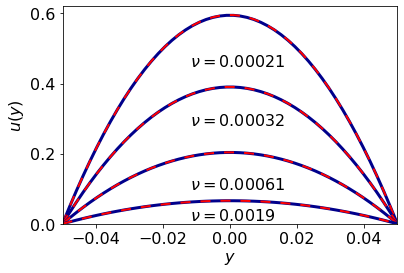

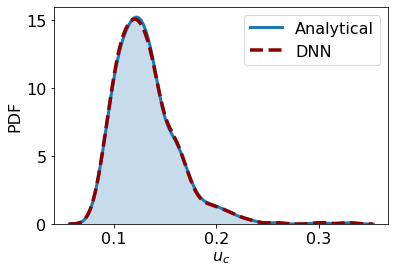

In [4]:
# prediction
import numpy as np
import matplotlib.pyplot as plt # For plotting
import pdb
import pandas as pd
import seaborn as sns
from scipy import stats

data1 = np.load("train_nu.npz")
#data1 = np.load('pipe_test_1dnu.npz')
nu = data1['nu_1d']
#nu = np.sort(nu)
print('nu is',nu)

############################
#profile viscosity

#ss
data = np.load('pred_poiseuille_para.npz')
mesh = data['mesh']
print('shape of mesh is',mesh.shape)
u = data['u']
v = data['v']
p = data['p']
ut = data['ut']
uMaxP=data['uMaxP']
uMaxA=data['uMaxA']
print("shape of uMaxA",uMaxA.shape)
Ny, Nx, Np = u.shape
print ("mesh shape = ", mesh.shape)
print ("u shape", u.shape)
idxP = 28


#idxP = np.array([0,28,49])
idxP = [3]
plot_x = 0.8
plot_y = 0.07
fontsize = 16

d = 0.1
#plot spanwise u profile along y, looping from nu_small to nu_large 
#u = data['u']
idx_X  = int(round(Nx/2))
y = np.linspace(-0.05,0.05,50)
can = [3,6,14,49]
#for idxP in range(len(nu)):
xtext= [0,0.5,1]
ytext = [0.45,0.28,0.1,0.01]
plt.figure(1)
Re = []
plt.figure(1)
plt.clf()
for idxP in range(len(can)):
    #plt.figure(1)
    #plt.clf()
    ax1 = plt.subplot(111)
    pT, = plt.plot(y,ut[:, idx_X, can[idxP]], color='darkblue', linestyle='-', lw=3.0, alpha=1.0)
    pP, = plt.plot(y,u[:, idx_X, can[idxP]],  color='red', linestyle='--', dashes=(5, 5), lw=2.0, alpha=1.0)
    tmpRe = np.max(u[:, idx_X, can[idxP]])*d/nu[can[idxP]]
    Re.append(tmpRe)
    #print("Re is",Re)
    nu_current = float("{0:.5f}".format(nu[can[idxP]]))
    #plt.title(r'$\nu = $' + str(nu_current))
    plt.text(-0.012,ytext[idxP],r'$\nu = $' + str(nu_current),{'color': 'k', 'fontsize': 16})
    

#plt.legend([pT, pP], ['Analytical', 'NN surrogate'], fontsize = 16,loc = 10)
plt.ylabel(r'$u(y)$', fontsize=16)
plt.xlabel(r'$y$', fontsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)     
ax1.set_xlim([-0.05, 0.05])
ax1.set_ylim([0.0, 0.62])
figureName = 'pipe_uProfiles_nuIdx_.png'
plt.savefig(figureName, bbox_inches='tight')

print('Re is',Re)
np.savez('test_Re',Re = Re)
plt.figure(2)
plt.clf()
ax1 = plt.subplot(111)
sns.kdeplot(uMaxA[0, :], shade=True, label='Analytical', linestyle="-", linewidth=3)
sns.kdeplot(uMaxP[0, :], shade=False, label='DNN', linestyle="--", linewidth=3.5, color='darkred')
plt.legend(prop={'size': 16})
plt.xlabel(r'$u_c$', fontsize=16)
plt.ylabel(r'PDF', fontsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)     
figureName = 'pipe_unformUQ.png'
plt.savefig(figureName, bbox_inches='tight')
plt.show()